# Header

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import spinmob as s
from scipy import interpolate as interpolate
from scipy import integrate as integrate
import os
import camb
import time
#%matplotlib notebook

In [3]:
# check directory
os.chdir("D:\Raphael\Dropbox\Mcgill\JupyterNotebook\PHYS512")
os.getcwd()

'D:\\Raphael\\Dropbox\\Mcgill\\JupyterNotebook\\PHYS512'

## Fonctions

In [4]:
def para(x,a,b,c):
    return a*x**2 + b*x + c

# Problem 1 (Done)
Before we start the main part of this problem set, let’s warm up with  linear least-squares problem. Look at the file dish zenith.txt. This contains photogrammetry data for a prototype telescope dish. Photogrammetry attempts to reconstruct surfaces by working out the 3-dimensional positions of targets from many pictures (as an aside, the algorithms behind photogrammetry are
another fun least-squares-type problem, but beyond the scope of this class). The end result is that dish zenith.txt contains the (x,y,z) positions in mm of a few hundred targets placed on the dish. The ideal telescope dish should be a rotationally symmetric paraboloid. We will try to measure the shape of that paraboloid, and see how well we did.

In [5]:
# Importing and storing the data by X,Y,Z
dish_zenith = s.data.load('dish_zenith.txt')
X = dish_zenith[0]
Y = dish_zenith[1]
Z = dish_zenith[2]
print("=> X Y Z loaded")

=> X Y Z loaded


## a)
Helpfully, I have oriented the points in the file so that the dish is pointing in the +z direction (in the general problem, you would have to fit for direction the dish is pointing in as well, but we will skip that here). For a rotationally
symmetric paraboloid, we know that

$$z − z_0 = a\big((x − x_0)^2 + (y − y_0)^2\big)$$

and we need to solve for x0, y0, z0, and a. While at first glance this problem may appear non-linear, show that we can pick a new set of parameters that make
the problem linear. What are these new parameters, and how do they relate to the old ones?

In [6]:
# First we define R^2 = X^2 + Y^2
R = np.sqrt(X**2 + Y**2)
# We thus obtain Z = a(R-R_0)^2 + Z_0
# we define:
#   b = -2aR_0
#   c = aR_0^2 + Z_0
# such that Z = aR^2 + bR + c

In [7]:
# Sort the R and Z in order of increasing R values
R_s = np.sort(R)
Z_s = np.zeros(len(R))
for i in range(len(R)):
    for j in range(len(R)):
        if R_s[i] == R[j]:
            Z_s[i] = Z[j]
R = R_s
Z = Z_s

## b)
Carry out the fit. What are your best-fit parameters?

In [8]:
# Using the least sqaure fit on a,b and c, lets define matrices:
# P x A = B  => P = A^(-1) x B
A = np.array([[np.sum(R**4),np.sum(R**3),np.sum(R**2)],
             [np.sum(R**3),np.sum(R**2),np.sum(R**1)],
             [np.sum(R**2),np.sum(R**1),np.sum(R**0)]])
A_inv = np.linalg.inv(A)
B = np.array([[np.sum(Z*R**2)],[np.sum(Z*R)],[np.sum(Z)]])
P = np.matmul(A_inv,B)
[a,b,c] = np.transpose(P)[0]
print("a =",a,"/ b = ",b,"/ c =",c)

a = 0.00016362088680435451 / b =  0.009977088801083056 / c = -1517.8966605425521


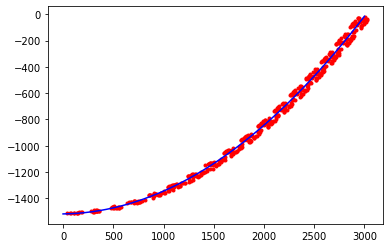

In [9]:
# Plot to see if the paramaters fit the data
plt.plot(R,Z,"r.")
r = np.linspace(0,3000,3001)
z = para(r,a,b,c)
plt.plot(r,z,"b-")

## c)
Estimate the noise in the data, and from that, estimate the uncertainty in a. Our target focal length was 1.5 metres. What did we actually get, and what is the error bar? In case all facets of conic sections are not at your immediate recall, a parabola that goes through (0, 0) can be written as $y = x^2/(4f)$ where f is the focal length. When calculating the error bar for the focal length, feel free to approximate using a first-order Taylor expansion.

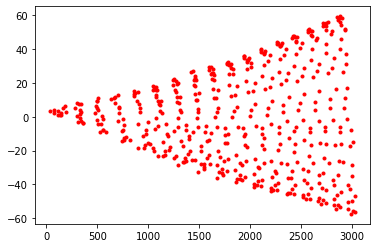

In [10]:
# Obtain the residual of the fit:
Res = R*0
for i in range(len(R)):
    Res[i] = Z[i]-para(R[i],a,b,c)
plt.plot(R,Res,"r.")

In [60]:
# defining A and N matrices as defined in the notes s.t. std(m) = sqrt((A^T N_inv A)^-1)
A = np.zeros(shape=(len(R),3))
for i in range(len(R)):
    for j in range(3):
        A[i][j] = R[i]**j
N_inv = np.zeros(shape=(len(R),len(R)))
for i in range(len(R)):
        N_inv[i][i] = 1/np.sqrt((d_y[i] - A_m[i])**2)

# compute std(m)
At = np.transpose(A)
C = np.matmul(np.matmul(At,N_inv),A)
C_inv = np.linalg.inv(C)
[c_std,b_std,a_std] = [np.sqrt(C_inv[0][0]),np.sqrt(C_inv[1][1]),np.sqrt(C_inv[2][2])]
print("a =",a,"+/-",a_std,"/ b = ",b,"+/-",b_std,"/ c =",c,"+/-",c_std)

a = 0.00016362088680435451 +/- 7.457823654454218e-07 / b =  0.009977088801083056 +/- 0.002534940256288118 / c = -1517.8966605425521 +/- 1.7447994280744947


**Thus, a = 0.0001636(7)**

In [12]:
# Now let's find the focal lenght
# First let's recenter the parabola at (0,0)
z_0 = z - c
#Now let's compute the focal lenght for all values of r in our fit.
f = r**2/(4*z_0)

In [13]:
#Averaging over all values of f and obtaining the uncertainty by taking the standart deviation of f.
f_avg = np.average(f[1:])
f_std = np.std(f[1:])
print("focal lenght = ",f_avg,"+/-",f_std)

focal lenght =  1406.5561538826203 +/- 177.17025909365162


**Thus, f = 1,4(2)m** according to our fit. It a agreens with the 1.5m target focal lenght.

# Problem 2 
Using Gaussian, uncorrelated errors, what do you get for $χ^2$ for the model in my example script, where the Hubble constant $H_0 = 65$ km/s, the physical baryon density $ω_bh^2=0.02$, the cold dark matter density $ω_ch^2 = 0.1$ the optical depth $τ = 0.05$, the primordial amplitude of fluctuations is $A_s = 2 × 10−9$ , and the slope of the primordial power law is $0.96$ (where 1 would be scale-invariant). The baryon/dark matter densities are defined relative to the critical density required to close the universe, scaled by $h^2$ where $h ≡ H_0/100 ∼ 0.7$. Note that the universe is assumed to be spatially flat (for reasons too long to justify here), so the dark matter density relative to critical for these parameters would be $1 − (ω_bh^2 + ω_ch^2 )/h^2 =71.6%$ for the model assumed here. (You may want to play around plotting different models as you change parameters to get a sense for how the CMB depends on them.) If everything has gone well, you should get something around 1588 (please give a few extra digits) for $χ^2$ for this model.

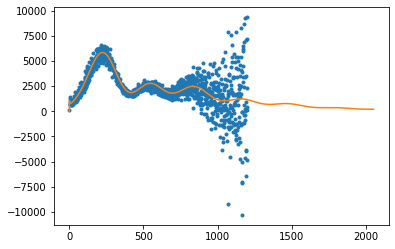

In [14]:
# Example script:
def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt


plt.ion()

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
plt.plot(wmap[:,0],wmap[:,1],'.')

cmb=get_spectrum(pars)
plt.plot(cmb)

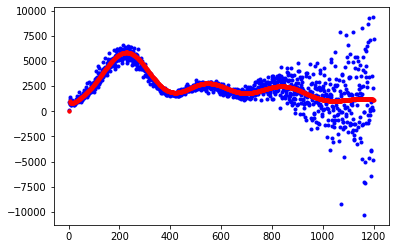

In [15]:
# Set data
[d_x,d_y] = [wmap[:,0],wmap[:,1]]
# Remove all pts in cmb outside of the range of the data.
A_m = cmb[0:len(d_x)]

# Testing by ploting:
plt.plot(d_x,d_y,"b.")
plt.plot(d_x,A_m,"r.")

In [62]:
# setting chi2 matrices
M = np.transpose([d_y - A_m])

N_inv = np.zeros(shape=(len(d_x),len(d_x))) # 1/sigma^2 matrix
for i in range(len(d_x)):
    sigma = np.sqrt((d_y[i] - A_m[i])**2)
    N_inv[i][i] = 1/(sigma)
    
Chi2 = np.matmul(np.matmul(np.transpose(M),N_inv),M)[0][0]
print("Chi2 = ",Chi2)

Chi2 =  933913.725620289


Clearly not the close from 1588... The error is clearly how I defined my N matrix, don't understand I shoudl do it however having only a fit value and a experimental value for every x.

# Problem 3
Keeping the optical depth fixed at 0.05, write a Newton’s method/LevenbergMarquardt minimizer and use it to find the best-fit values for the other parameters, and their errors. What are they? If you were to keep the same set of parameter but now float $τ$ , what would you expect the new errors to be? Note that CAMB does not provide derivatives with respect to parameters, so you’ll
have to come up with something for that. Pleae also provide a plot showing why we should believe your derivative estimates.

In [111]:
def calc_spectrum(pars,t,lmax=1200)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    
    #Grad measurement:
    grad=np.zeros([t.size,pars.size])
    d = 1e-4
    grad = (8*f(x+d) - 8*f(x-d) - f(x+2*d) + f(x-2*d))/(12*d)
    
    
    return tt



t = d_x
p0 = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
p=p0.copy()

<IPython.core.display.Javascript object>


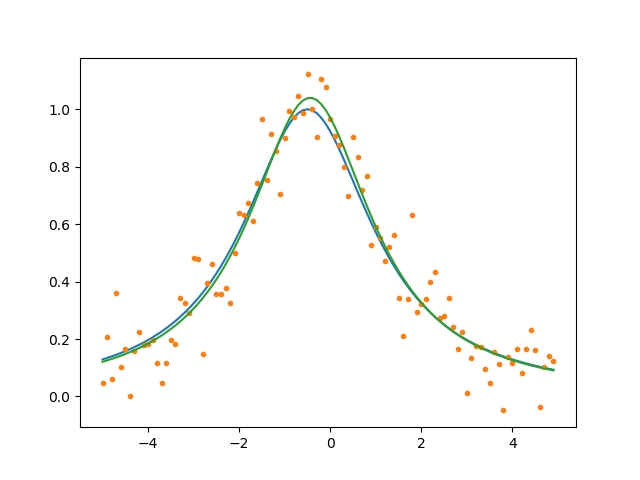

[ 2.83128519  2.57009099 -0.46536203] 4.1445692986391
[ 2.84138523  2.72498891 -0.44412405] 0.9092627685167917
[ 2.8418118   2.73289298 -0.44194363] 0.8468880279916586
[ 2.84172615  2.73280111 -0.44189553] 0.8467328778098892
[ 2.84172975  2.73280566 -0.44189514] 0.8467328637147381


In [107]:
def calc_lorentz(p,t):
    y=p[0]/(p[1]+(t-p[2])**2)
    grad=np.zeros([t.size,p.size])
    #now differentiate w.r.t. all the parameters
    grad[:,0]=1.0/(p[1]+(t-p[2])**2)
    grad[:,1]=-p[0]/(p[1]+(t-p[2])**2)**2
    grad[:,2]=p[0]*2*(t-p[2])/(p[1]+(t-p[2])**2)**2
    return y,grad

t=np.arange(-5,5,0.1)
p_true=np.array([3,3,-0.5])
x_true,grad=calc_lorentz(p_true,t)
x=x_true+0.1*np.random.randn(t.size)
plt.ion()
plt.clf()
plt.plot(t,x_true)
plt.plot(t,x,'.')
p0=np.array([2,3,-0.4]) #starting guess, close but not exact

p=p0.copy()
for j in range(5):
    pred,grad=calc_lorentz(p,t)
    r=x-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
    print (p,err)
plt.plot(t,pred)
plt.savefig('lorentz_fit.png')
#2.0/(3.0+(t-0.5)**2) + 0.2*numpy.random.randn(t.size)


# Problem 4
Now write a Markov-chain Monte Carlo where you fit the basic 6 parameters, including $τ$ . However, note that we know the optical depth can’t be negative, so you should reject any steps that try to sample a negative $τ$ . What are your parameter limits now? Please also present an argument as to why you think your chains are converged. As a reminder, you can draw samples of correlated data from a covariance matrix with r = np.linalg.cholesky(mat); d = np.dot(r, np.random.randn(r.shape[0])). You will want to use the covariance matrix from part 2) when drawing samples for the MCMC.

# Problem 5
The Planck satellite has independently measured the CMB sky, and finds that the optical depth is 0.0544 ± 0.0073. Run a chain where you add this in as a prior on the value of τ . What are your new parameter values/constraints? You can also take your chain from part 4) and importance sample it (weighting by the prior) with the Planck τ prior. How to those results compare to the full chain results?